## TEC: spatial and temporal variation

In [1]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from scipy import interpolate, stats
from matplotlib import pyplot as plt, colorbar, ticker, colors

from mintpy.objects import sensor
from mintpy.utils import ptime, readfile, writefile
from tools.simulation import iono
from tools import iono_tec
plt.rcParams.update({'font.size': 12})
Re = 6378122.65 #m

proj_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src')
work_dir = os.path.join(proj_dir, 'TEC')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# aux info
tec_dir = os.path.expanduser('~/data/aux/IGS_TEC')
tf_file = os.path.join(proj_dir, 'data/NISAR_track_frames/tframe_left_look.gpkg')
tf_out_file = os.path.join(work_dir, 'tframe_left_look.gpkg')

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC


### Download JLR TEC for the year of 2014 and 2019

In [2]:
tec_files = []
for year in range(2014, 2020):
    date_list = ptime.get_date_range(f'{year}0101', f'{year}1231')
    tec_files += iono_tec.download_igs_tec(date_list, tec_dir, tec_sol='jpl')


------------------------------------------------------------------------------
downloading GNSS TEC products from NASA's Archive of Space Geodesy Data (CDDIS) ...
Link: https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 365
ALL files exists with consistent file size, skip re-downloading.
[001/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0010.14i: 860086
[002/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0020.14i: 860086
[003/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0030.14i: 860086
[004/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0040.14i: 860167
[005/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0050.14i: 860167
[006/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0060.14i: 860086
[007/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0070.14i: 860086
[008/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0080.14i: 860086
[009/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0090.14i: 860086
[010/365] /Users/yunjunz/data/aux/IGS_TEC/jplg0100.14i: 860086
[011/365] /Users/y

### Write TEC to HDF5 file

In [3]:
# grab size info
lons, lats, mins = iono.read_ionex_tec(tec_files[0])[:3]
num_map = len(mins) - 1
num_lat = lats.size
num_lon = lons.size

dt_list  = ptime.get_date_range('2014-01-01T00', '2014-12-31T22', dstep=int(24/num_map), dunit='h', out_fmt='%Y-%m-%dT%H:%M')
dt_list += ptime.get_date_range('2019-01-01T00', '2019-12-31T22', dstep=int(24/num_map), dunit='h', out_fmt='%Y-%m-%dT%H:%M')
date_list  = ptime.get_date_range('20140101', '20141231', dstep=1, dunit='D', out_fmt='%Y%m%d')
date_list += ptime.get_date_range('20190101', '20191231', dstep=1, dunit='D', out_fmt='%Y%m%d')
num_date = len(date_list)

# read IONEX files
re_generate_hdf5_file = False
if not os.path.isfile(tec_h5_file) or re_generate_hdf5_file:
    ds_tec = np.zeros((num_date * num_map, num_lat, num_lon), dtype=np.float32)
    prog_bar = ptime.progressBar(maxValue=num_date)
    for i, tec_file in enumerate(tec_files):
        tec_maps = iono.read_ionex_tec(tec_file)[3][0]
        for j in range(num_map):
            ds_tec[i * num_map + j, :] = tec_maps[:, :, j].T
        prog_bar.update(i+1, suffix=date_list[i])
    prog_bar.close()

    # write to one HDF5/MintPy file
    ds_dict = {
        'date' : np.array(dt_list, dtype=np.string_),
        'timeseries' : ds_tec,
    }
    meta = {
        'LENGTH'    : num_lat,
        'WIDTH'     : num_lon,
        'FILE_TYPE' : 'timeseries',
        'DATA_TYPE' : 'float32',
        'UNIT'      : 'TECU',
        'X_FIRST'   : lons[0] - np.diff(lons)[0]/2,
        'Y_FIRST'   : lats[0] - np.diff(lats)[0]/2,
        'X_STEP'    : np.diff(lons)[0],
        'Y_STEP'    : np.diff(lats)[0],
        'X_UNIT'    : 'degrees',
        'Y_UNIT'    : 'degrees',
        'HEIGHT'    : iono.grab_ionex_height(tec_files[0]),
    }
    writefile.write(ds_dict, tec_h5_file, metadata=meta)

### Grab TEC time-series for each track and frame

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
tfs = gpd.read_file(tf_file)
tfs.crs = "EPSG:4326"

flagA = tfs.passDirection.isin(['Ascending'])
flagD = tfs.passDirection.isin(['Descending'])

# total bounding box [to guide the plot extent]
W, S, E, N = tfs.total_bounds
print('S, N, W, E = {}'.format((S, N, W, E)))

/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


S, N, W, E = (-88.0555860632601, 77.62878280455716, -180.0, 180.0)


In [9]:
# calc lat/lon for the center of frames on the ground
centroid = tfs.geometry.to_crs("EPSG:4326").centroid
# correct frames crossing the 180 longitude [int. date line]
xmin = tfs.geometry.bounds.minx
xmax = tfs.geometry.bounds.maxx
inds = np.where((xmax - xmin) > 180)[0]
for ind in inds:
    polys = list(tfs.iloc[ind].geometry)
    areas = [p.area for p in polys]
    centroid[ind] = polys[np.argmax(areas)].centroid

# calc lat/lon of the center of frames on the ionospheric thin shell
hgt_ion = 450e3
xoff = (tfs.satelliteLon - centroid.x)
xoff[xoff >  180] -= 360.
xoff[xoff < -180] += 360.
lon_ion = centroid.x + hgt_ion / tfs.satelliteHeight * xoff
lat_ion = centroid.y + hgt_ion / tfs.satelliteHeight * (tfs.satelliteLat - centroid.y)
lon_ion[lon_ion >=  180] -= 360.
lon_ion[lon_ion <= -180] += 360.

# write lat/lon to file
tfs['groundLon'] = centroid.x
tfs['groundLat'] = centroid.y
tfs['ionoPiercingPointLon'] = lon_ion
tfs['ionoPiercingPointLat'] = lat_ion
if not os.path.isfile(tf_out_file):
    tfs.to_file(tf_out_file, driver='GPKG')
    print('write to file: {}'.format(tf_out_file))

# plot longitude to make sure the value is right across the int. date line
plot_IPP_loc = False
if plot_IPP_loc:
    fig, ax = plt.subplots(figsize=[6, 3])
    tfs[flagA].plot(ax=ax, facecolor=cmap((lon_ion[flagA]+180)/360), edgecolor='none')
    world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
    ax.set_aspect('equal');  ax.set_xlim(-180, 180);  ax.set_ylim(-87.5, 78)
    fig.tight_layout()
    plt.show()

# get datetime objects of one cycle [from J2000/ephemeris time to UTC]
dts_sat = [dt.datetime(2000,1,1,12,0,0) + dt.timedelta(seconds=(tf.startET + tf.endET)/2.0) for i, tf in tfs.iterrows()]
mins_sat = [x.hour * 60. + x.minute + x.second / 60. for x in dts_sat]

solar_timeA = ptime.utc2solar_time(np.array(dts_sat)[flagA][1],    centroid.x.to_numpy()[flagA][1])
solar_timeD = ptime.utc2solar_time(np.array(dts_sat)[flagD][1000], centroid.x.to_numpy()[flagD][1000])
print('Asc  local solar time: {}'.format(solar_timeA.time()))
print('Desc local solar time: {}'.format(solar_timeD.time()))

# get datetime objects of all TEC grids
tec_file = iono.get_igs_tec_filename(tec_dir, '20140101')
lons, lats, mins = iono.read_ionex_tec(tec_file)[:3]

/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Asc  local solar time: 05:37:14.217321
Desc local solar time: 18:32:46.517842


In [14]:
# calculate TEC time-series for all frames
years = np.arange(2014, 2020)
tec_tf_files = [os.path.join(work_dir, f'TEC_tframe_{year}.csv') for year in years]
re_calc = False
for year, tec_tf_file in zip(years, tec_tf_files):
    if not os.path.isfile(tec_tf_file) or re_calc:
        # calc TEC on each frame
        date_rng = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
        num_date = date_rng.size
        tec_tfs = np.zeros((num_date, tfs.geometry.count()), dtype=np.float32)
        prog_bar = ptime.progressBar(maxValue=num_date)
        for i in range(num_date):
            date_str = date_rng[i].strftime('%Y%m%d')
            tec_file = iono.get_igs_tec_filename(tec_dir, date_str)
            tec_grid = iono.read_ionex_tec(tec_file)[3][0]
            tec_tfs[i, :] = interpolate.interpn(
                points=(lons, np.flip(lats), mins),
                values=np.flip(tec_grid, axis=1),
                xi=(lon_ion, lat_ion, mins_sat),
                method='linear',
            )
            prog_bar.update(i+1, suffix=date_str)
        prog_bar.close()

        # write TEC time-series to CSV file using pandas
        prog_bar = ptime.progressBar(maxValue=tfs.geometry.count())
        tec_df = pd.DataFrame(date_rng, columns=['date'])
        for i, row in tfs.iterrows():
            col_name = f'track{row.track}-frame{row.frame}'
            tec_df[col_name] = tec_tfs[:, i]
            prog_bar.update(i+1, every=176, suffix=col_name.split('-')[0])
        prog_bar.close()
        tec_df = tec_df.set_index('date')
        print('write to file: {}'.format(tec_tf_file))
        tec_df.to_csv(tec_tf_file)

# read for stats and ploting
tec_dfs = []
for tec_ts_file in tec_tf_files:
    print('reading {}'.format(tec_ts_file))
    tec_dfs.append(pd.read_csv(tec_ts_file, index_col=0))

[==================================================] 20141231   87s /     1s 
[==================================================] track173   68s /     1s 
write to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_tframe_2014.csv
[==================================================] 20151231   78s /     1s 
[==================================================] track173   79s /     1s 
write to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_tframe_2015.csv
[==================================================] 20161231   93s /     1s 
[==================================================] track173   88s /     1s 
write to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_tframe_2016.csv
[==================================================] 20171231   80s /     1s 
[==================================================] track173   76s /     1s 
write to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_tframe_2017.csv
[===========================

## Plot

### Stats

In [15]:
for tec_df, year in zip(tec_dfs, years):
    print(f'Year: {year}')
    print('  mean [min/mean/max]: {:5.1f} / {:5.1f} / {:5.1f}'.format(tec_df.mean().min(), tec_df.mean().mean(), tec_df.mean().max()))
    print('  std  [min/mean/max]: {:5.1f} / {:5.1f} / {:5.1f}'.format(tec_df.std().min(),  tec_df.std().mean(),  tec_df.std().max()))

Year: 2014
  mean [min/mean/max]:   7.9 /  24.0 /  77.0
  std  [min/mean/max]:   3.0 /   8.8 /  25.7
Year: 2015
  mean [min/mean/max]:   6.4 /  19.3 /  61.5
  std  [min/mean/max]:   2.4 /   7.5 /  22.6
Year: 2016
  mean [min/mean/max]:   4.5 /  13.3 /  40.0
  std  [min/mean/max]:   1.3 /   4.7 /  15.2
Year: 2017
  mean [min/mean/max]:   3.7 /  10.6 /  29.7
  std  [min/mean/max]:   1.0 /   3.3 /   9.7
Year: 2018
  mean [min/mean/max]:   2.8 /   9.1 /  25.4
  std  [min/mean/max]:   0.7 /   2.8 /   8.7
Year: 2019
  mean [min/mean/max]:   2.6 /   8.6 /  22.9
  std  [min/mean/max]:   0.7 /   2.6 /   8.1


### Maps: solar min/max

A2014 min / mean / max:  7.9 / 16.2 / 22.5
A2019 min / mean / max:  2.6 /  6.4 / 10.3
D2014 min / mean / max:  8.5 / 31.7 / 77.0
D2019 min / mean / max:  4.0 / 10.7 / 22.9
save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_mean_map.png


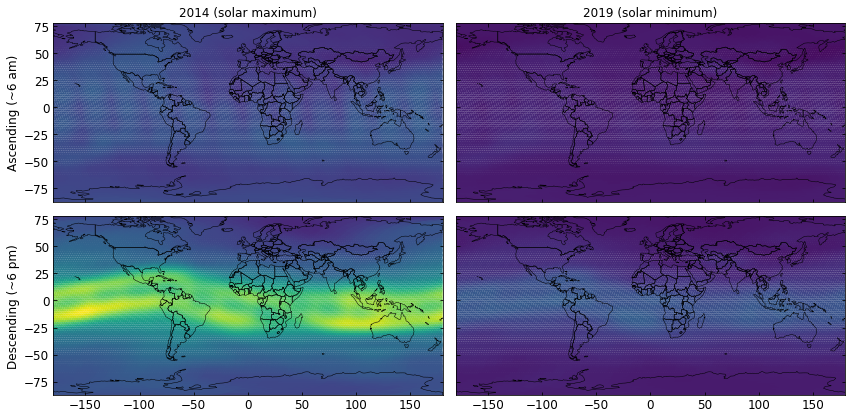

In [26]:
label = 'mean';  vmax = 77.5
#label = 'STD';   vmax = 25

if label == 'mean':
    dDict = {'A2014' : {'data': tec_dfs[years.tolist().index(2014)].mean().to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': tec_dfs[years.tolist().index(2019)].mean().to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': tec_dfs[years.tolist().index(2014)].mean().to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': tec_dfs[years.tolist().index(2019)].mean().to_numpy()[flagD], 'flag': flagD}}
else:
    dDict = {'A2014' : {'data': tec_dfs[years.tolist().index(2014)].std().to_numpy()[flagA], 'flag': flagA},
             'A2019' : {'data': tec_dfs[years.tolist().index(2019)].std().to_numpy()[flagA], 'flag': flagA},
             'D2014' : {'data': tec_dfs[years.tolist().index(2014)].std().to_numpy()[flagD], 'flag': flagD},
             'D2019' : {'data': tec_dfs[years.tolist().index(2019)].std().to_numpy()[flagD], 'flag': flagD}}
keys = list(dDict.keys())
# stats
for key, v in dDict.items():
    print('{} min / mean / max: {:4.1f} / {:4.1f} / {:4.1f}'.format(key, np.min(v['data']), np.mean(v['data']), np.max(v['data'])))

# plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[12, 6], sharex=True, sharey=True)
axs = axs.flatten()
cmap = plt.get_cmap('viridis')
for i, (ax, key) in enumerate(zip(axs, keys)):
    v = dDict[key]
    tfs[v['flag']].plot(ax=ax, facecolor=cmap(v['data']/vmax), edgecolor='none')
    world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)

# axis format
for ax in axs: ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
ax = axs[0]
ax.set_aspect('equal')
ax.set_xlim(-180, 180)
ax.set_ylim(-87.5, 78)
axs[0].set_ylabel('Ascending (~6 am)')
axs[2].set_ylabel('Descending (~6 pm)')
axs[0].set_title('2014 (solar maximum)', fontsize=12)
axs[1].set_title('2019 (solar minimum)', fontsize=12)
fig.tight_layout()

# output
out_fig = os.path.abspath(f'TEC_{label.lower()}_map.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

max VTEC: 77.5 [TECU]
max range delay: 25.3 [m] for NISAR-L
save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_mean_map_cbar.png


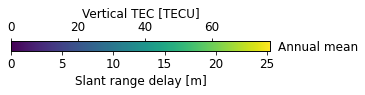

In [28]:
label = 'mean';  vmax = 77.5
#label = 'STD';   vmax = 25

inc_angle = 42
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)
rg_max = iono.vtec2range_delay(vmax, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
print('max VTEC: {} [TECU]'.format(vmax))
print('max range delay: {:.1f} [m] for NISAR-L'.format(rg_max))

# colorbars
# link: https://stackoverflow.com/questions/27151098/draw-colorbar-with-twin-scales
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(4, 0.15))
ax = fig.add_axes([0.05, 0.05, 0.95, 0.95])

# define my own ScalarMappable instead of relying on imshow() 
norm = colors.Normalize(vmin=0, vmax=rg_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# create the colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')

# the aspect of the colorbar is set to 'equal', we have to set it to 'auto',
# otherwise twinx() will do weird stuff.
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')
# create a second axes instance and set the limits you need
ax2 = cbar.ax.twiny()
ax2.set_xlim([0, vmax])
# resize the colorbar (otherwise it overlays the plot)
pos.x0 += 0.05
cbar.ax.set_position(pos)
ax2.set_position(pos)

cbar.ax.set_xlabel('Slant range delay [m]')
ax2.set_xlabel('Vertical TEC [TECU]')
ax.annotate(f'Annual {label}', xy=(1.03, 0.), xycoords='axes fraction')

# output
out_fig = os.path.abspath(f'TEC_{label.lower()}_map_cbar.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### Profiles: multi-years

save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TEC/TEC_std_lat.png


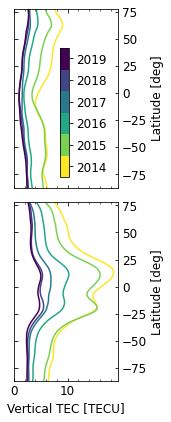

In [30]:
label = 'mean'
label = 'STD'

bin_rng = (-88, 78);  bin_step = 2;
num_bin = int((bin_rng[1] - bin_rng[0]) / bin_step); bin_cen = np.arange(bin_rng[0], bin_rng[1], bin_step) + bin_step/2
cmap = plt.get_cmap('viridis_r', lut=len(tec_dfs))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[2.5, 6], sharex=True, sharey=True)
for ax, flag in zip(axs, [flagA, flagD]):
    tlat = centroid.y.to_numpy()[flag]
    for i, (tec_df, year) in enumerate(zip(tec_dfs, years)):
        if label == 'mean':
            tval = tec_df.mean().to_numpy()[flag]
        else:
            tval = tec_df.std().to_numpy()[flag]
        bin_tec = stats.binned_statistic(x=tlat, values=tval, bins=num_bin, range=bin_rng)[0]
        ax.plot(bin_tec, bin_cen, color=cmap(i))
# axis format
for ax in axs:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
    ax.set_ylabel('Latitude [deg]')
axs[1].set_ylim(-87.5, 78)
axs[1].set_xlim(0)
axs[1].set_xlabel('Vertical TEC [TECU]')
axs[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.tight_layout()
fig.subplots_adjust(hspace=0.08)

# colorbar
cax = fig.add_axes([0.35, 0.58, 0.05, 0.3])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, ticks=(np.arange(len(years)) + 0.5) / len(years))
cbar.ax.set_yticklabels(years)

# output
out_fig = os.path.abspath(f'TEC_{label.lower()}_lat.png')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

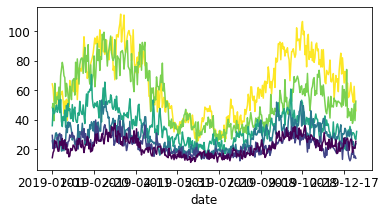

In [180]:
# track frame number for Mexico City
inds = np.where((centroid.x > -101) & (centroid.x < -97) & (centroid.y > 17) & (centroid.y < 21))[0]
indA, indD = inds[1], inds[-2]
tfnameA = 'track{}-frame{}'.format(tfs.iloc[indA].track, tfs.iloc[indA].frame)
tfnameD = 'track{}-frame{}'.format(tfs.iloc[indD].track, tfs.iloc[indD].frame)

# plot
cmap = plt.get_cmap('viridis_r', lut=len(tec_dfs))
fig, ax = plt.subplots(figsize=[6, 3])
for i, tec_df in enumerate(tec_dfs):
    tec_df[tfnameA].plot(ax=ax, color=cmap(i))
plt.show()